In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,15)

In [2]:
beta = 10
lam = 10
r = .95
delta = .01
S1_0 = 0
S2_0 = 1
p1_tf = 0
p2_tf = 0
tf = 40
Sbar = 1
n = 40*12

In [3]:
#Code from RK4 Lab with minor edits
def initialize_all(y0, t0, tf, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h."""
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    Y[0] = y0
    T = np.linspace(t0, tf, n)
    h = float(tf - t0) / (n - 1)
    return Y, T, h

def RK4(f, y0, t0, tf, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    f is assumed to accept three arguments.
    The first is a constant giving the value of t.
    The second is a one-dimensional numpy array of the same size as y.
    The third is an index to the other arrays.
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,tf,n)
    for i in range(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y

In [17]:
# initialize global variables, state, costate, and u.
state = np.zeros((n,2))
state0 = np.array([S1_0, S2_0])

costate = np.zeros((n,2))
costate0 = np.zeros(2)

u=np.zeros(n)
u[:] += .1

# define state equations
def state_equations(t,y,i):
    '''
    Parameters
    ---------------
    t : float
    the time
    y : ndarray (2,)
    the T cell concentration and the Virus concentration at time t
    i : int
    index for the global variable u.
    Returns
    --------------
    y_dot : ndarray (2,)
    the derivative of the T cell concentration and the virus ←-
    concentration at time t
    '''
    y_dot = np.zeros_like(y)
    y_dot[0] = u[i] - delta*y[0]
    y_dot[1] = Sbar * y[1] - y[1]**2 - u[i]
    return y_dot

In [18]:
def lambda_hat(t,y,i):
    '''
    Parameters
    ---------------
    t : float
    the time
    y : ndarray (2,)
    the lambda_hat values at time t
    i : int
    index for global variables, u and state.
    Returns
    --------------
    y_dot : ndarray (2,)
    the derivative of the lambda_hats at time t.
    '''
    y_dot = np.zeros_like(y)
    y_dot[0] = delta*y[0] + beta*np.exp(state[-i-1,0]-r*t)
    y_dot[1] = y[1]*(2*state[-i-1,1] - Sbar) - lam*u[-i-1]*np.exp(-r*tf+r*t) / (state[-i-1,1]**2)
    return y_dot


In [19]:
epsilon = 0.001
test = epsilon + 1
z = np.zeros(n)

while(test > epsilon):
    oldu = u.copy();
    
    #solve the state equations with forward iteration
    state = RK4(state_equations, state0, 0, tf, n)
    
    #solve the costate equations with backwards iteration
    costate = RK4(lambda_hat, costate0, 0, tf, n)[::-1]
    
    #solve for u1 and u2
    u1 = np.maximum(z, costate[:,1] / (lam + state[:,1]*np.exp(r*np.linspace(0,tf,n))*(state[:,1] - costate[:,0])))
    '''u1 = np.minimum(u1, state[:,1])'''
    
    #u1 = costate[:,1] / (lam + state[:,1]*np.exp(r*np.linspace(0,tf,n))*(state[:,1] - costate[:,0]))
    
    #update control
    u = 0.5*(u1 + oldu)
    
    #test for convergence
    test = abs(oldu - u).sum()

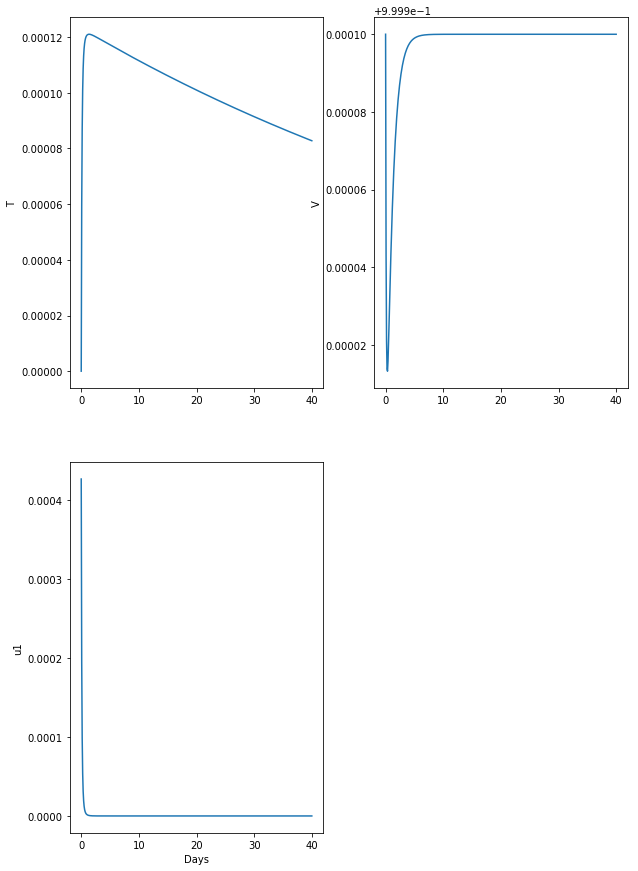

In [20]:
domain = np.linspace(0, tf, n)

plt.subplot(221)
plt.plot(domain, state[:,0])
plt.ylabel("T")

plt.subplot(222)
plt.plot(domain, state[:,1])
plt.ylabel("V")

plt.subplot(223)
plt.plot(domain, u)
plt.ylabel("u1")
plt.xlabel("Days")

plt.show()

In [21]:
state

array([[0.00000000e+00, 1.00000000e+00],
       [5.93621888e-05, 9.99943025e-01],
       [8.69448478e-05, 9.99921068e-01],
       [1.01012679e-04, 9.99913820e-01],
       [1.08736716e-04, 9.99913229e-01],
       [1.13235940e-04, 9.99915775e-01],
       [1.15984134e-04, 9.99919794e-01],
       [1.17727246e-04, 9.99924453e-01],
       [1.18865414e-04, 9.99929318e-01],
       [1.19624245e-04, 9.99934157e-01],
       [1.20136555e-04, 9.99938844e-01],
       [1.20483560e-04, 9.99943314e-01],
       [1.20716612e-04, 9.99947535e-01],
       [1.20869165e-04, 9.99951495e-01],
       [1.20963606e-04, 9.99955193e-01],
       [1.21015280e-04, 9.99958636e-01],
       [1.21034939e-04, 9.99961834e-01],
       [1.21030265e-04, 9.99964799e-01],
       [1.21006851e-04, 9.99967545e-01],
       [1.20968833e-04, 9.99970085e-01],
       [1.20919316e-04, 9.99972432e-01],
       [1.20860663e-04, 9.99974600e-01],
       [1.20794695e-04, 9.99976601e-01],
       [1.20722831e-04, 9.99978448e-01],
       [1.206461

In [22]:
u

array([4.27131833e-04, 1.95459140e-04, 9.86102415e-05, 5.37934699e-05,
       3.12879502e-05, 1.91976673e-05, 1.23233926e-05, 8.22087181e-06,
       5.66795359e-06, 4.02035379e-06, 2.92245404e-06, 2.16989365e-06,
       1.64096933e-06, 1.26086037e-06, 9.82235713e-07, 7.74370937e-07,
       6.16847870e-07, 4.95803001e-07, 4.01635793e-07, 3.27575756e-07,
       2.68767148e-07, 2.21672702e-07, 1.83678057e-07, 1.52824866e-07,
       1.27627862e-07, 1.06947596e-07, 8.99006540e-08, 7.57954823e-08,
       6.40859277e-08, 5.43372003e-08, 4.62006518e-08, 3.93948800e-08,
       3.36914267e-08, 2.89038443e-08, 2.48792601e-08, 2.14918112e-08,
       1.86374911e-08, 1.62300753e-08, 1.41978765e-08, 1.24811425e-08,
       1.10299585e-08, 9.80254583e-09, 8.76387528e-09, 7.88453218e-09,
       7.13978351e-09, 6.50880828e-09, 5.97406061e-09, 5.52074104e-09,
       5.13635662e-09, 4.81035388e-09, 4.53381214e-09, 4.29918673e-09,
       4.10009353e-09, 3.93112813e-09, 3.78771370e-09, 3.66597290e-09,
      

In [23]:
costate

array([[ 1.55411402e+01, -6.49858065e-04],
       [ 1.55281676e+01, -3.42947756e-04],
       [ 1.55152059e+01, -1.95000280e-04],
       [ 1.55022550e+01, -1.17926045e-04],
       [ 1.54893149e+01, -7.51102923e-05],
       [ 1.54763856e+01, -5.00032691e-05],
       [ 1.54634670e+01, -3.45841228e-05],
       [ 1.54505593e+01, -2.47287673e-05],
       [ 1.54376623e+01, -1.82061192e-05],
       [ 1.54247761e+01, -1.37546105e-05],
       [ 1.54119007e+01, -1.06326426e-05],
       [ 1.53990360e+01, -8.38904053e-06],
       [ 1.53861821e+01, -6.74079437e-06],
       [ 1.53733388e+01, -5.50545666e-06],
       [ 1.53605063e+01, -4.56248345e-06],
       [ 1.53476845e+01, -3.83044747e-06],
       [ 1.53348735e+01, -3.25323287e-06],
       [ 1.53220731e+01, -2.79145925e-06],
       [ 1.53092834e+01, -2.41703113e-06],
       [ 1.52965043e+01, -2.10960007e-06],
       [ 1.52837360e+01, -1.85422368e-06],
       [ 1.52709782e+01, -1.63978876e-06],
       [ 1.52582312e+01, -1.45793163e-06],
       [ 1.